# Simple Generative Adversarial Nets 

### Introduction 

Generative Adversarial Nets (GANs) is a state-of-the-art deep neural networks, which was introduced by Ian GoodFellow 
in 2014. Relevant paper can be downloaded from the Internet(Generative Adversarial Networks,  Ian Goodfellow, et al. 2014).  

To understand this deeply, first you will have to understand what a generative model is. In machine learning, the two main classes of models are __Generative Model__ and __Discriminative Model__. A discriminative model is one that discriminates between two(or more) different classes of data, for example, a convolutional neural network(discriminator) is trained to output 1 given an image of a cat and 0 otherwise. A generative model on the other hand doesn't know anything about classes of data. Instead, its purpose is to generate data which fits the distribution of the training data, for example, a Gaussian Mixture Model is a generative model which, fater trained on a set of points, is able to generate new random points which more-or-less fit the distribution of the training data. 

As the structure show below, the GANs train the __Generator__(generative model)and the __Discriminator__(discriminative Model) simultaneously. Given a set of Data Sample (such as images), we can imagine that there is an underlying distribution (x) that governs them. With GANs, G will generate outputs and D will decide if they come from the same distribution of the the data sample or generator sample.
G will start from some noise z, so the generated images are G(z). D takes images from the distribution (real) and fake (from G) and classifies them: D(x) and D(G(z)).

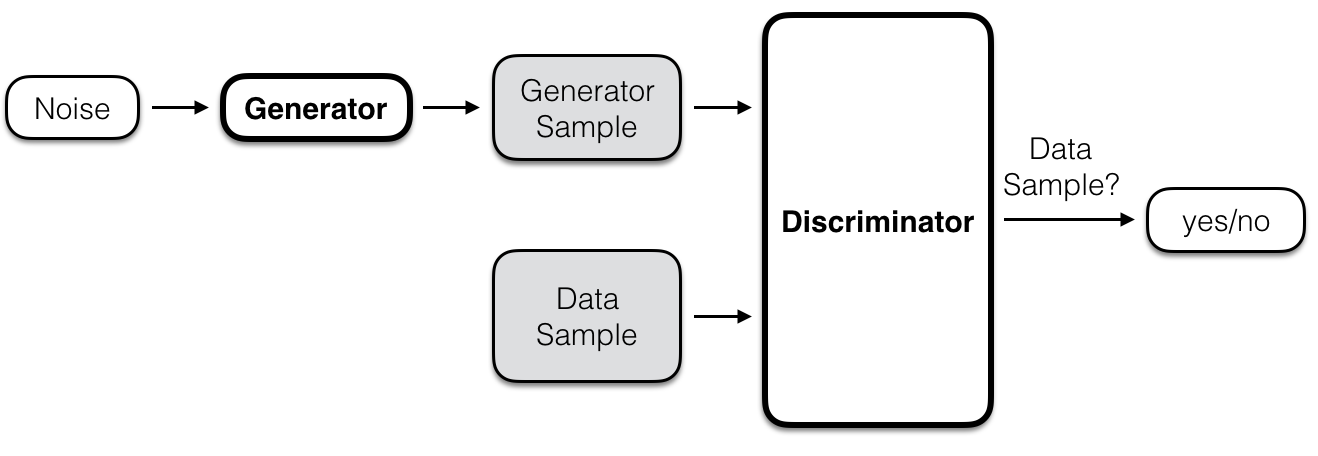

In [1]:
from IPython.display import Image
Image(filename='figures/GANs_structure.png')

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline

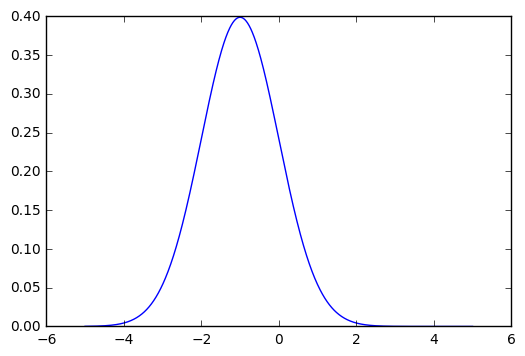

In [3]:
mu, sigma = -1, 1                     # mu is the mean, sigma is the variance
x_input = np.linspace(-5,5,1000)             # This is going to be our data sample
y_input = norm.pdf(x_input, loc=mu, scale=sigma)  # y is the pdf of x
plt.plot(x_input, y_input)
plt.show()

In [4]:
TRAIN_ITERS = 10000  # train iterations 
MINI_BATCH = 200    # size of minibatch

In [5]:
def mlp(input, output_dim):
    # parameters in local scope
    w0 = tf.get_variable(name='w0', shape=[input.get_shape()[1], 6], initializer=tf.random_normal_initializer())
    b0 = tf.get_variable(name='b0', shape=[6], initializer=tf.constant_initializer())
    w1 = tf.get_variable(name='w1', shape=[6, 5], initializer=tf.random_normal_initializer())
    b1 = tf.get_variable(name='b1', shape=[5], initializer=tf.constant_initializer())
    w2 = tf.get_variable(name='w2', shape=[5, output_dim], initializer=tf.random_normal_initializer())
    b2 = tf.get_variable(name='b2', shape=[output_dim], initializer=tf.constant_initializer())
    
    # neural networks operators
    layer1 = tf.nn.tanh(tf.matmul(input, w0) + b0)
    layer2 = tf.nn.tanh(tf.matmul(layer1, w1) + b1)
    layer3 = tf.nn.tanh(tf.matmul(layer2, w2) + b2)
    
    return layer3, [w0, b0, w1, b1, w2, b2]

In [6]:
def momentum_optimizer(loss, var_list):
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(learning_rate=0.001,
                                               global_step=global_step,
                                               decay_steps=TRAIN_ITERS//4,
                                               decay_rate=0.95,
                                               staircase=True)
    optimizer = tf.train.MomentumOptimizer(learning_rate, 
                                           momentum=0.9).minimize(loss=loss,
                                                                  global_step=global_step,
                                                                  var_list=var_list)
    return optimizer

In [7]:
with tf.variable_scope('D_pre'):
    input_node = tf.placeholder(tf.float32, shape=(MINI_BATCH, 1)) 
    train_labels = tf.placeholder(tf.float32, shape=(MINI_BATCH, 1))
    D, weights = mlp(input_node, 1)
    loss = tf.reduce_mean(tf.square(D - train_labels))
optimizer = momentum_optimizer(loss, None)

In [8]:
sess = tf.InteractiveSession()
tf.initialize_all_variables().run()

In [9]:
# plot decision surfaces
def plot_d0(D, input_node, x, y):
    f, ax = plt.subplots(1)
    ax.plot(x, y, label='data_pdf')
    # decision boundary
    x_db = x
    y_db = np.zeros((1000,1))
    # process multiple points in parallel in a minibatch
    for i in range(int(1000/MINI_BATCH)):
        x_minibatch = np.reshape(x[MINI_BATCH*i : MINI_BATCH*(i+1)], (MINI_BATCH, 1))
        y_db[MINI_BATCH*i : MINI_BATCH*(i+1)] = sess.run(D, {input_node: x_minibatch})
    ax.plot(x_db, y_db, label='decision boundary')
    ax.set_ylim(0, 1.1)
    plt.legend()

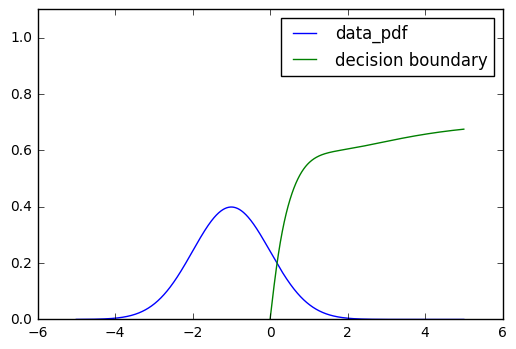

In [10]:
plot_d0(D, input_node, x_input, y_input)

In [11]:
lh = np.zeros(1000)
for i in range(1000):
    d = (np.random.random(MINI_BATCH)-0.5) * 10.0
    labels = norm.pdf(d, loc=mu, scale=sigma)
    lh[i], _ = sess.run([loss, optimizer], 
                       {input_node: np.reshape(d, (MINI_BATCH, 1)),
                        train_labels: np.reshape(labels, (MINI_BATCH,1))})

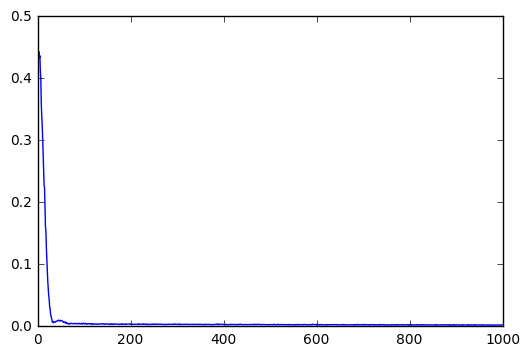

In [12]:
# Training Loss
plt.plot(lh)

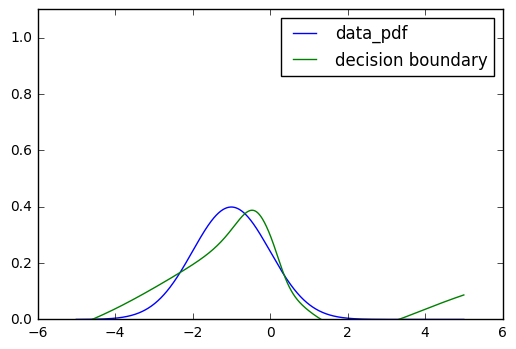

In [13]:
plot_d0(D, input_node, x_input, y_input)

In [14]:
# copy the learned weights over into a tmp array
weightsD = sess.run(weights)

In [15]:
# close the pre-training session
sess.close()

###### Build GANs
now to build the actual generative adversarial network

In [16]:
with tf.variable_scope("G"):
    z_node = tf.placeholder(tf.float32, shape=(MINI_BATCH,1))
    G, weights_G = mlp(z_node, 1) # scale up by 5 to match range
    G = tf.mul(5.0, G)

In [17]:
with tf.variable_scope("D") as scope:
    x_node = tf.placeholder(tf.float32, shape=(MINI_BATCH, 1))
    fc, weights_D = mlp(x_node, 1)
    D1 = tf.maximum(tf.minimum(fc, 0.99), 0.01)
    scope.reuse_variables()
    fc, weights_D = mlp(G,1)
    D2 = tf.maximum(tf.minimum(fc, 0.99), 0.01)

obj_d = tf.reduce_mean(tf.log(D1)+tf.log(1-D2))
obj_g = tf.reduce_mean(tf.log(D2))
# set up optimizer for G, D
opt_d = momentum_optimizer(1-obj_d, weights_D)
opt_g = momentum_optimizer(1-obj_g, weights_G)

In [18]:
sess = tf.InteractiveSession()
tf.initialize_all_variables().run()

In [19]:
for i, v in enumerate(weights_D):
    sess.run(v.assign(weightsD[i]))

In [20]:
def plot_fig():
    f, ax = plt.subplots(1)
    xs = np.linspace(-5,5,1000)
    ax.plot(xs, norm.pdf(xs,loc=mu,scale=sigma),label='data_pdf')
    # decision_boundary
    r = 5000
    xs = np.linspace(-5,5,r)
    ds = np.zeros((r,1))
    for i in range(int(r/MINI_BATCH)):
        x = np.reshape(xs[MINI_BATCH*i:MINI_BATCH*(i+1)], (MINI_BATCH,1))
        ds[MINI_BATCH*i:MINI_BATCH*(i+1)] = sess.run(D1,{x_node:x})
    ax.plot(xs, ds, label='decison boundary')
    
    zs = np.linspace(-5,5,r)
    gs = np.zeros((r,1))
    for i in range(int(r/MINI_BATCH)):
        z = np.reshape(xs[MINI_BATCH*i:MINI_BATCH*(i+1)], (MINI_BATCH,1))
        gs[MINI_BATCH*i:MINI_BATCH*(i+1)] = sess.run(G,{z_node:z})
    histc, edges = np.histogram(gs, bins=10)
    ax.plot(np.linspace(-5,5,10), histc/float(r), label='generator_pdf')
    ax.set_ylim(0, 1.1)
    plt.legend()

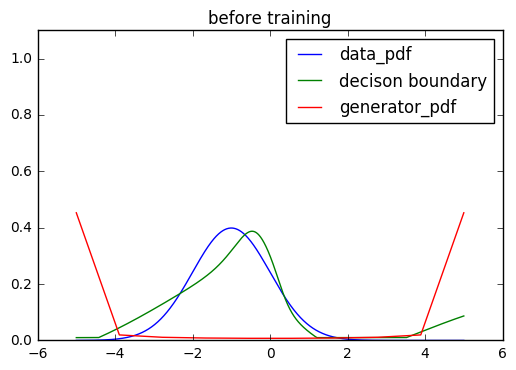

In [21]:
plot_fig()
plt.title('before training')

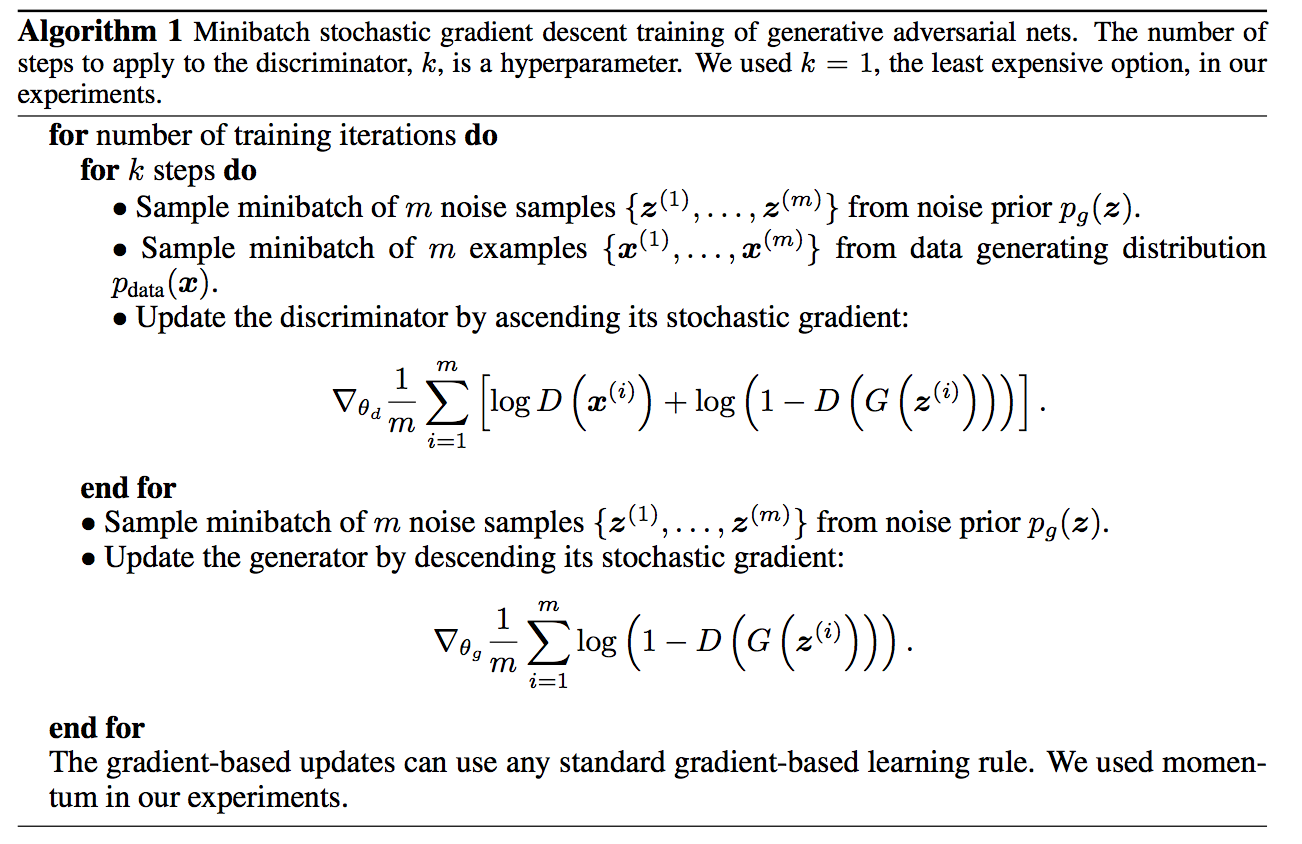

In [22]:
Image(filename='figures/GANs_algorithm.png', width=600, height=600)

In [23]:
k = 1
histd, histg = np.zeros(TRAIN_ITERS), np.zeros(TRAIN_ITERS)
for i in range(TRAIN_ITERS):
    for j in range(k):
        x = np.random.normal(mu, sigma, MINI_BATCH) # sample m-batch from p_data
        x.sort()
        Z = np.linspace(-5.0, 5.0, MINI_BATCH) + np.random.random(MINI_BATCH) * 0.01
        # sess run the momentum optimizer(opt_d) and return the loss function(obj_d)
        histd[i], _ = sess.run([obj_d, opt_d], {x_node: np.reshape(x, (MINI_BATCH,1)),
                                                z_node: np.reshape(Z, (MINI_BATCH,1))})
        
        Z = np.linspace(-5.0, 5.0, MINI_BATCH) + np.random.random(MINI_BATCH)*0.01
        # sess run the momentum optimizer(opt_g) and return the loss function(obj_g)
        histg[i], _ = sess.run([obj_g, opt_g], {z_node: np.reshape(Z, (MINI_BATCH,1))})
        if i%(TRAIN_ITERS//10)==0:
            print(float(i)/float(TRAIN_ITERS))

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


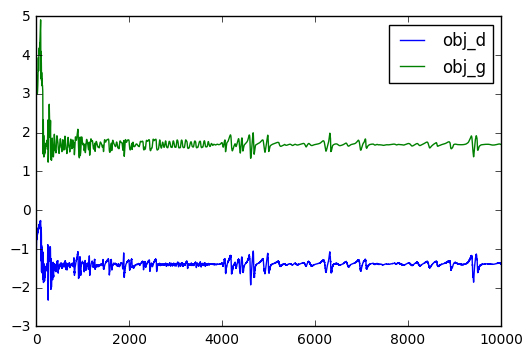

In [24]:
plt.plot(range(TRAIN_ITERS), histd, label='obj_d')
plt.plot(range(TRAIN_ITERS), 1-histg, label='obj_g')
plt.legend()

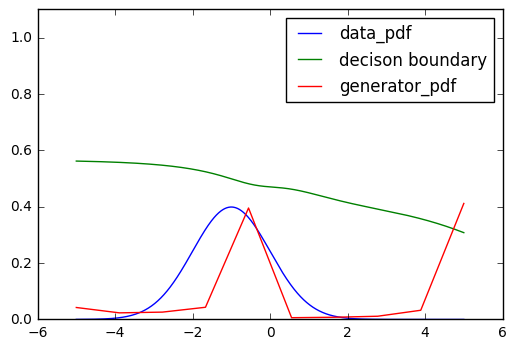

In [25]:
plot_fig()